#***▶ Configuración Inicial y Descarga de Datos***

*   **DESCRIPCIÓN:** Clasificación multi-label de enfermedades en hojas de manzano
*   **TÉCNICAS:** Redes Convolucionales, Transfer Learning, Data Augmentation

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"duvan0598","key":"dd66d6752e8b1194f147e8c526826508"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Descargar los datos de la competencia Plant Pathology 2020
!kaggle competitions download -c plant-pathology-2020-fgvc7

 86% 668M/779M [00:03<00:02, 50.3MB/s]
100% 779M/779M [00:03<00:00, 209MB/s] 


In [ ]:
# Crear directorios organizados
!mkdir -p /content/plant_raw
!mkdir -p /content/plant_processed
!unzip plant-pathology-2020-fgvc7.zip -d /content/plant_raw

Archive:  plant-pathology-2020-fgvc7.zip
  inflating: /content/plant_raw/images/Test_0.jpg  
  inflating: /content/plant_raw/images/Test_1.jpg  
  inflating: /content/plant_raw/images/Test_10.jpg  
  inflating: /content/plant_raw/images/Test_100.jpg  
  inflating: /content/plant_raw/images/Test_1000.jpg  
  inflating: /content/plant_raw/images/Test_1001.jpg  
  inflating: /content/plant_raw/images/Test_1002.jpg  
  inflating: /content/plant_raw/images/Test_1003.jpg  
  inflating: /content/plant_raw/images/Test_1004.jpg  
  inflating: /content/plant_raw/images/Test_1005.jpg  
  inflating: /content/plant_raw/images/Test_1006.jpg  
  inflating: /content/plant_raw/images/Test_1007.jpg  
  inflating: /content/plant_raw/images/Test_1008.jpg  
  inflating: /content/plant_raw/images/Test_1009.jpg  
  inflating: /content/plant_raw/images/Test_101.jpg  
  inflating: /content/plant_raw/images/Test_1010.jpg  
  inflating: /content/plant_raw/images/Test_1011.jpg  
  inflating: /content/plant_raw/im

In [ ]:
from google.colab import files
import pandas as pd
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import cv2
import os
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

#***▶ Análisis Exploratorio de Datos***:

In [ ]:
print("=== ANÁLISIS EXPLORATORIO DE DATOS ===")

# Cargar y analizar datos de entrenamiento
df = pd.read_csv("/content/plant_raw/train.csv")
print(f"Total de imágenes: {len(df)}")
print(f"Distribución de clases:")
print(df[['healthy', 'multiple_diseases', 'rust', 'scab']].sum())

# Verificar balance de clases
class_distribution = df[['healthy', 'multiple_diseases', 'rust', 'scab']].sum()
print(f"\nDistribución porcentual:")
print((class_distribution / len(df) * 100).round(2))

=== ANÁLISIS EXPLORATORIO DE DATOS ===
Total de imágenes: 1821
Distribución de clases:
healthy              516
multiple_diseases     91
rust                 622
scab                 592
dtype: int64

Distribución porcentual:
healthy              28.34
multiple_diseases     5.00
rust                 34.16
scab                 32.51
dtype: float64



#***▶ Preprocesamiento de Datos***:

In [ ]:
# Configuración global
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def analyze_images(df, images_dir):
    """
    Analiza dimensiones y características de las imágenes
    """
    print("="*50)
    print("\t\tANÁLISIS DE IMÁGENES")
    print("="*50)
    sample_img_path = f"{images_dir}/{df.iloc[0]['image_id']}.jpg"
    sample_img = cv2.imread(sample_img_path)
    print(f"Dimensión de imagen sample: {sample_img.shape}")

    # Verificar existencia de todas las imágenes
    missing_images = []
    for img_id in df['image_id']:
        if not os.path.exists(f"{images_dir}/{img_id}.jpg"):
            missing_images.append(img_id)

    if missing_images:
        print(f"⚠️  Imágenes faltantes: {len(missing_images)}")
    else:
        print("✅ Todas las imágenes encontradas")

analyze_images(df, "/content/plant_raw/images")

		ANÁLISIS DE IMÁGENES
Dimensión de imagen sample: (1365, 2048, 3)
✅ Todas las imágenes encontradas


## ***Creación de TFRecords***

In [ ]:
def serialize_example(image_bytes, label):
    """
    Serializa imagen y etiquetas para TFRecord
    CORRECCIÓN: No usar .shape en bytes object
    """
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_bytes])),
        'label': tf.train.Feature(float_list=tf.train.FloatList(value=label)),
    }
    proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return proto.SerializeToString()

def create_tfrecords_dataset(df, images_dir, output_path):
    """
    Crea dataset TFRecord a partir del DataFrame - VERSIÓN CORREGIDA
    """
    print("=== CREANDO TFRecord DATASET ===")

    with tf.io.TFRecordWriter(output_path) as writer:
        successful = 0
        errors = []

        for i, row in tqdm(df.iterrows(), total=len(df), desc="Procesando imágenes"):
            try:
                img_path = f"{images_dir}/{row['image_id']}.jpg"

                # Preprocesar imagen
                img = preprocess_image(img_path)
                img_bytes = img.tobytes()

                # Preparar etiquetas (multi-hot encoding)
                labels = df.columns[1:]  # ['healthy', 'multiple_diseases', 'rust', 'scab']
                label_values = row[labels].values.astype(np.float32)

                # Serializar y escribir - CORREGIDO
                example = serialize_example(img_bytes, label_values)
                writer.write(example)
                successful += 1

            except Exception as e:
                errors.append((row['image_id'], str(e)))
                continue

        print(f"✅ Imágenes procesadas exitosamente: {successful}/{len(df)}")
        if errors:
            print(f"⚠️  Errores: {len(errors)}")
            for img_id, error in errors[:5]:
                print(f"   - {img_id}: {error}")

    return successful, errors

# También mejoremos la función de preprocesamiento con más verificaciones
def preprocess_image(img_path, target_size=IMAGE_SIZE):
    """
    Preprocesa imagen: redimensiona, normaliza y convierte a RGB
    """
    # Verificar que el archivo existe
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Imagen no encontrada: {img_path}")

    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"No se pudo decodificar la imagen: {img_path}")

    # Convertir a RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Redimensionar
    img = cv2.resize(img, target_size)

    # Verificar dimensiones
    if img.shape != (*target_size, 3):
        print(f"Advertencia: imagen {os.path.basename(img_path)} tiene shape {img.shape}")

    return img

# Crear directorio de salida si no existe
os.makedirs("/content/plant_processed", exist_ok=True)

# Crear el dataset TFRecord - VERSIÓN CORREGIDA
tfrecord_path = "/content/plant_processed/plant_dataset.tfrecord"
successful, errors = create_tfrecords_dataset(df, "/content/plant_raw/images", tfrecord_path)

=== CREANDO TFRecord DATASET ===


Procesando imágenes: 100%|██████████| 1821/1821 [00:43<00:00, 41.95it/s]

✅ Imágenes procesadas exitosamente: 1821/1821


## ***Pipeline de Datos Optimizado***

In [ ]:
def parse_tfrecord(example_proto):
    """
    Parsea ejemplos TFRecord para el entrenamiento
    """
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([4], tf.float32),
    }
    parsed = tf.io.parse_single_example(example_proto, features)

    # Decodificar imagen
    img = tf.io.decode_raw(parsed['image'], tf.uint8)
    img = tf.reshape(img, [*IMAGE_SIZE, 3])
    img = tf.cast(img, tf.float32) / 255.0  # Normalización [0,1]

    return img, parsed['label']

def create_data_pipeline(tfrecord_path, batch_size=32, shuffle_buffer=1000,
                        augmentation=True, is_training=True):
    """
    Crea pipeline de datos optimizado para entrenamiento/validación
    """
    # Data augmentation más robusto
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
    ])

    # Cargar dataset
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=AUTOTUNE)

    if is_training:
        # Solo aplicar shuffle durante entrenamiento
        dataset = dataset.shuffle(shuffle_buffer)

        if augmentation:
            # Aplicar data augmentation
            dataset = dataset.map(
                lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE
            )

    # Optimizaciones finales
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset

# Crear datasets de entrenamiento y validación
print("=== CREANDO DATASETS ===")

# Split entrenamiento/validación (80/20)
train_size = int(0.8 * successful)
val_size = successful - train_size

# En una implementación real, separaríamos los datos
# Por simplicidad, usaremos el mismo dataset
train_ds = create_data_pipeline(tfrecord_path, batch_size=BATCH_SIZE,
                               augmentation=True, is_training=True)

# Para validación, crear sin aumento de datos
val_ds = create_data_pipeline(tfrecord_path, batch_size=BATCH_SIZE,
                             augmentation=False, is_training=False)

print(f"Dataset de entrenamiento listo")
print(f"Dataset de validación listo")

=== CREANDO DATASETS ===
Dataset de entrenamiento listo
Dataset de validación listo


## ***Verificación Final***

In [ ]:
# Verificar un batch del dataset
for images, labels in train_ds.take(1):
  print("="*50)
  print(f"\t\tVERIFICACIÓN DATASET")
  print("="*50)
  print(f"Shape de imágenes batch: {images.shape}")
  print(f"Shape de etiquetas batch: {labels.shape}")
  print(f"Rango de píxeles: [{tf.reduce_min(images):.3f}, {tf.reduce_max(images):.3f}]")
  print(f"Ejemplo de etiquetas: {labels[0].numpy()}")
  break

print("\n✅ PREPROCESADO COMPLETADO EXITOSAMENTE")

		VERIFICACIÓN DATASET
Shape de imágenes batch: (32, 224, 224, 3)
Shape de etiquetas batch: (32, 4)
Rango de píxeles: [0.000, 51.271]
Ejemplo de etiquetas: [0. 0. 1. 0.]

✅ PREPROCESADO COMPLETADO EXITOSAMENTE


In [ ]:
# =============================================================================
# 1. SEPARACIÓN CORRECTA DE DATOS - ENTRENAMIENTO/VALIDACIÓN
# =============================================================================

print("🎯 SEPARANDO DATOS EN ENTRENAMIENTO Y VALIDACIÓN...")

# Mezclar el DataFrame original para mejor distribución
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Calcular split 80/20
train_size = int(0.8 * len(df_shuffled))
train_df = df_shuffled[:train_size]
val_df = df_shuffled[train_size:]

print(f"✅ Datos separados:")
print(f"   • Entrenamiento: {len(train_df)} imágenes")
print(f"   • Validación: {len(val_df)} imágenes")

# =============================================================================
# 2. CREAR TFRecords SEPARADOS
# =============================================================================

# Crear TFRecord para entrenamiento
train_tfrecord_path = "/content/plant_processed/train_dataset.tfrecord"
print(f"\n💾 Creando TFRecord de entrenamiento...")
train_successful, train_errors = create_tfrecords_dataset(
    train_df, "/content/plant_raw/images", train_tfrecord_path
)

# Crear TFRecord para validación
val_tfrecord_path = "/content/plant_processed/val_dataset.tfrecord"
print(f"💾 Creando TFRecord de validación...")
val_successful, val_errors = create_tfrecords_dataset(
    val_df, "/content/plant_raw/images", val_tfrecord_path
)

# =============================================================================
# 3. CREAR PIPELINES SEPARADOS
# =============================================================================

print("\n🔧 CREANDO PIPELINES SEPARADOS...")

# Pipeline de ENTRENAMIENTO (con data augmentation)
train_ds_final = create_data_pipeline(
    train_tfrecord_path,
    batch_size=BATCH_SIZE,
    shuffle_buffer=1000,
    augmentation=True,
    is_training=True
)

# Pipeline de VALIDACIÓN (sin data augmentation)
val_ds_final = create_data_pipeline(
    val_tfrecord_path,
    batch_size=BATCH_SIZE,
    shuffle_buffer=0,  # No shuffle en validación
    augmentation=False,
    is_training=False
)

print("✅ Pipelines creados:")
print(f"   • Entrenamiento: con data augmentation y shuffle")
print(f"   • Validación: sin augmentation, sin shuffle")

# =============================================================================
# 4. ANÁLISIS DE BALANCE DE CLASES
# =============================================================================

print("\n⚖️ ANALIZANDO BALANCE DE CLASES...")

# Distribución en entrenamiento
train_dist = train_df[['healthy', 'multiple_diseases', 'rust', 'scab']].sum()
print("📊 DISTRIBUCIÓN ENTRENAMIENTO:")
for label in ['healthy', 'multiple_diseases', 'rust', 'scab']:
    count = train_dist[label]
    percentage = (count / len(train_df)) * 100
    print(f"   • {label:20}: {count:3d} imágenes ({percentage:5.1f}%)")

# Distribución en validación
val_dist = val_df[['healthy', 'multiple_diseases', 'rust', 'scab']].sum()
print("\n📊 DISTRIBUCIÓN VALIDACIÓN:")
for label in ['healthy', 'multiple_diseases', 'rust', 'scab']:
    count = val_dist[label]
    percentage = (count / len(val_df)) * 100
    print(f"   • {label:20}: {count:3d} imágenes ({percentage:5.1f}%)")

# Calcular class weights para manejar desbalance
class_weights = {}
total_train = len(train_df)
labels = ['healthy', 'multiple_diseases', 'rust', 'scab']

for i, label in enumerate(labels):
    count = train_dist[label]
    if count > 0:
        weight = total_train / (len(labels) * count)
        class_weights[i] = weight
    else:
        class_weights[i] = 1.0

print(f"\n🎯 CLASS WEIGHTS (para training):")
for i, label in enumerate(labels):
    print(f"   • {label:20}: {class_weights[i]:.3f}")

# =============================================================================
# 5. VERIFICACIÓN FINAL
# =============================================================================

print("\n🔍 VERIFICACIÓN FINAL DE DATASETS...")

# Verificar dataset de entrenamiento
print("📚 DATASET DE ENTRENAMIENTO:")
for images, labels in train_ds_final.take(1):
    print(f"   • Batch shape: {images.shape}")
    print(f"   • Labels shape: {labels.shape}")
    print(f"   • Rango píxeles: [{tf.reduce_min(images):.3f}, {tf.reduce_max(images):.3f}]")
    print(f"   • Ejemplo label: {labels[0].numpy()}")

# Verificar dataset de validación
print("\n📚 DATASET DE VALIDACIÓN:")
for images, labels in val_ds_final.take(1):
    print(f"   • Batch shape: {images.shape}")
    print(f"   • Labels shape: {labels.shape}")
    print(f"   • Rango píxeles: [{tf.reduce_min(images):.3f}, {tf.reduce_max(images):.3f}]")

# =============================================================================
# 6. RESUMEN FINAL
# =============================================================================

print("\n" + "="*60)
print("🎉 PREPROCESADO 100% COMPLETADO")
print("="*60)

print(f"📊 RESUMEN FINAL:")
print(f"   • Total imágenes: {len(df)}")
print(f"   • Entrenamiento: {len(train_df)} imágenes")
print(f"   • Validación: {len(val_df)} imágenes")
print(f"   • TFRecords: ✅ Separados (train/val)")
print(f"   • Data augmentation: ✅ Solo en entrenamiento")
print(f"   • Class weights: ✅ Calculados")
print(f"   • Pipelines: ✅ Optimizados")

print(f"\n🚀 VARIABLES LISTAS PARA EL MODELO:")
print(f"   • train_ds_final: Dataset de entrenamiento")
print(f"   • val_ds_final: Dataset de validación")
print(f"   • class_weights: Pesos para clases desbalanceadas")

🎯 SEPARANDO DATOS EN ENTRENAMIENTO Y VALIDACIÓN...
✅ Datos separados:
   • Entrenamiento: 1456 imágenes
   • Validación: 365 imágenes

💾 Creando TFRecord de entrenamiento...
=== CREANDO TFRecord DATASET ===


Procesando imágenes: 100%|██████████| 1456/1456 [00:24<00:00, 58.73it/s]


✅ Imágenes procesadas exitosamente: 1456/1456
💾 Creando TFRecord de validación...
=== CREANDO TFRecord DATASET ===


Procesando imágenes: 100%|██████████| 365/365 [00:05<00:00, 62.25it/s]


✅ Imágenes procesadas exitosamente: 365/365

🔧 CREANDO PIPELINES SEPARADOS...
✅ Pipelines creados:
   • Entrenamiento: con data augmentation y shuffle
   • Validación: sin augmentation, sin shuffle

⚖️ ANALIZANDO BALANCE DE CLASES...
📊 DISTRIBUCIÓN ENTRENAMIENTO:
   • healthy             : 405 imágenes ( 27.8%)
   • multiple_diseases   :  71 imágenes (  4.9%)
   • rust                : 505 imágenes ( 34.7%)
   • scab                : 475 imágenes ( 32.6%)

📊 DISTRIBUCIÓN VALIDACIÓN:
   • healthy             : 111 imágenes ( 30.4%)
   • multiple_diseases   :  20 imágenes (  5.5%)
   • rust                : 117 imágenes ( 32.1%)
   • scab                : 117 imágenes ( 32.1%)

🎯 CLASS WEIGHTS (para training):
   • healthy             : 0.899
   • multiple_diseases   : 5.127
   • rust                : 0.721
   • scab                : 0.766

🔍 VERIFICACIÓN FINAL DE DATASETS...
📚 DATASET DE ENTRENAMIENTO:
   • Batch shape: (32, 224, 224, 3)
   • Labels shape: (32, 4)
   • Rango píxeles: [0

#***▶ Construccion del Modelo CNN - Clasificación Multi-Label***:




In [ ]:
from tensorflow.keras import models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
import matplotlib.pyplot as plt

## ***Configuración del Modelo***

In [ ]:
# Parámetros del modelo
INPUT_SHAPE = (224, 224, 3)  # Mismo que en preprocesado
NUM_CLASSES = 4               # healthy, multiple_diseases, rust, scab
DROPOUT_RATE = 0.5
LEARNING_RATE = 0.001

print("="*55)
print("\tConfiguración del modelo:")
print("="*55)
print(f"   • Input shape: {INPUT_SHAPE}")
print(f"   • Número de clases: {NUM_CLASSES}")
print(f"   • Learning rate: {LEARNING_RATE}")

	Configuración del modelo:
   • Input shape: (224, 224, 3)
   • Número de clases: 4
   • Learning rate: 0.001


## ***Arquitectura CNN desde Cero***

In [ ]:
# Crea un modelo CNN desde cero para clasificación multi-label
def create_cnn_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, dropout_rate=DROPOUT_RATE):
  print("Construyendo arquitectura CNN desde cero...")

  model = models.Sequential([
      # Capa Input explícita (recomendado)
      layers.Input(shape=input_shape, name='input_layer'),

      # Bloque convolucional 1
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1'),
      layers.BatchNormalization(name='bn1'),
      layers.MaxPooling2D((2, 2), name='pool1'),
      layers.Dropout(dropout_rate * 0.5, name='drop1'),

      # Bloque convolucional 2
      layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
      layers.BatchNormalization(name='bn2'),
      layers.MaxPooling2D((2, 2), name='pool2'),
      layers.Dropout(dropout_rate * 0.6, name='drop2'),

      # Bloque convolucional 3
      layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'),
      layers.BatchNormalization(name='bn3'),
      layers.MaxPooling2D((2, 2), name='pool3'),
      layers.Dropout(dropout_rate * 0.7, name='drop3'),

      # Bloque convolucional 4
      layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4'),
      layers.BatchNormalization(name='bn4'),
      layers.MaxPooling2D((2, 2), name='pool4'),
      layers.Dropout(dropout_rate, name='drop4'),

      # Capas fully connected
      layers.Flatten(name='flatten'),
      layers.Dense(512, activation='relu', name='dense1'),
      layers.BatchNormalization(name='bn5'),
      layers.Dropout(dropout_rate, name='drop5'),

      layers.Dense(256, activation='relu', name='dense2'),
      layers.BatchNormalization(name='bn6'),
      layers.Dropout(dropout_rate * 0.8, name='drop6'),

      # Capa de salida (multi-label)
      layers.Dense(num_classes, activation='sigmoid', name='output')
  ])

  return model

# Crear el modelo (sin warnings)
cnn_model = create_cnn_model()

Construyendo arquitectura CNN desde cero...


## ***Copilación del Modelo***

In [ ]:
#Compila el modelo con optimizer, loss function y métricas para multi-label
def compile_model(model, learning_rate=LEARNING_RATE):
    print("Compilando modelo...")

    # Optimizer
    optimizer = Adam(learning_rate=learning_rate)

    # Loss function para multi-label classification
    loss = 'binary_crossentropy'  # Para múltiples etiquetas independientes

    # Métricas para evaluación multi-label
    metrics = [
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc', multi_label=True)  # Importante para multi-label
    ]

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    # Mostrar nombres de métricas sin causar error
    metric_names = []
    for metric in metrics:
        if hasattr(metric, 'name'):
            metric_names.append(metric.name)
        else:
            metric_names.append(metric)

    print("✅ Modelo compilado:")
    print(f"   • Optimizer: Adam (lr={learning_rate})")
    print(f"   • Loss: {loss}")
    print(f"   • Metrics: {metric_names}")

    return model

# Compilar el modelo
cnn_model = compile_model(cnn_model)

Compilando modelo...
✅ Modelo compilado:
   • Optimizer: Adam (lr=0.001)
   • Loss: binary_crossentropy
   • Metrics: ['accuracy', 'precision', 'recall', 'auc']


## ***Resumen y Visualización del Modelo***

In [ ]:
print("\n" + "="*60)
print("\t\t\t\tRESUMEN DEL MODELO CNN")
print("="*60 + "\n")

# Mostrar arquitectura
cnn_model.summary()

# Visualización de la arquitectura
try:
    tf.keras.utils.plot_model(
        cnn_model,
        to_file='/content/cnn_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB'
    )
    print("\nArquitectura guardada en: /content/cnn_architecture.png")
except Exception as e:
    print(f"No se pudo generar visualización: {e}")


				RESUMEN DEL MODELO CNN



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 224, 224, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 112, 112, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 56, 56, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 28, 28, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop4 (Dropout)                 │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop5 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn6 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop6 (Dropout)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,216,388 (100.01 MB)

 Trainable params: 26,213,892 (100.00 MB)

 Non-trainable params: 2,496 (9.75 KB)


Arquitectura guardada en: /content/cnn_architecture.png


## ***Callbacks Para Entrenamiento***

In [ ]:
#Configuración de callbacks para mejorar el entrenamiento
def setup_training_callbacks():
  print("Configurando callbacks...")

  callbacks = [
    # Early Stopping: Detener entrenamiento si no mejora
    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      patience=10,
      restore_best_weights=True,
      verbose=1
    ),

    # Reduce Learning Rate on Plateau: Reducir LR si se estanca
    tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.5,
      patience=5,
      min_lr=1e-7,
      verbose=1
    ),

    # Model Checkpoint: Guardar mejor modelo
    tf.keras.callbacks.ModelCheckpoint(
      '/content/best_cnn_model.h5',
      monitor='val_loss',
      save_best_only=True,
      save_weights_only=False,
      verbose=1
    ),
  ]

  print("Callbacks configurados:")
  print("   • EarlyStopping (patience=10)")
  print("   • ReduceLROnPlateau (factor=0.5, patience=5)")
  print("   • ModelCheckpoint (best model)")

  return callbacks

# Configurar callbacks
training_callbacks = setup_training_callbacks()


Configurando callbacks...
Callbacks configurados:
   • EarlyStopping (patience=10)
   • ReduceLROnPlateau (factor=0.5, patience=5)
   • ModelCheckpoint (best model)


## ***Verificación Final Antes del Entrenamiento***

In [ ]:
print("\n" + "="*60)
print("\t\tVERIFICACIÓN FINAL PRE-ENTRENAMIENTO")
print("="*60 + "\n")

# Verificar que los datasets estén listos
print("Verificando datasets...")
try:
  # Probar un batch de entrenamiento
  for images, labels in train_ds_final.take(1):
    print(f"   • Train batch - Images: {images.shape}, Labels: {labels.shape}")
    break

  # Probar un batch de validación
  for images, labels in val_ds_final.take(1):
    print(f"   • Val batch - Images: {images.shape}, Labels: {labels.shape}")
    break
  print("   ✅ Datasets listos")
except Exception as e:
  print(f"   ❌ Error con datasets: {e}")

# Verificar class weights
print(f"\nClass weights: {class_weights}")

# Verificar compatibilidad modelo-datos
sample_input_shape = next(iter(train_ds_final))[0].shape[1:]
expected_input_shape = cnn_model.input_shape[1:]

print(f"\nCompatibilidad input shapes:")
print(f"   • Esperado por modelo: {expected_input_shape}")
print(f"   • Proveniente de datos: {sample_input_shape}")

if sample_input_shape == expected_input_shape:
  print("   ✅ Shapes compatibles")
else:
  print("   ❌ ERROR: Shapes incompatibles")


		VERIFICACIÓN FINAL PRE-ENTRENAMIENTO

Verificando datasets...
   • Train batch - Images: (32, 224, 224, 3), Labels: (32, 4)
   • Val batch - Images: (32, 224, 224, 3), Labels: (32, 4)
   ✅ Datasets listos

Class weights: {0: np.float64(0.8987654320987655), 1: np.float64(5.126760563380282), 2: np.float64(0.7207920792079208), 3: np.float64(0.7663157894736842)}

Compatibilidad input shapes:
   • Esperado por modelo: (224, 224, 3)
   • Proveniente de datos: (224, 224, 3)
   ✅ Shapes compatibles


## ***Entrenamiento del Modelo***

In [ ]:
print("\n" + "="*60)
print("INICIANDO ENTRENAMIENTO DEL MODELO CNN")
print("="*60 + "\n")

# Parámetros de entrenamiento
EPOCHS = 30  # Máximo de épocas (early stopping puede detener antes)

print(f"Parámetros de entrenamiento:")
print(f"   • Épocas máximas: {EPOCHS}")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Samples entrenamiento: {len(train_df)}")
print(f"   • Samples validación: {len(val_df)}")
print(f"   • Class weights aplicados: ✅")

# Entrenar el modelo
print("\nIniciando entrenamiento...")

history = cnn_model.fit(
    train_ds_final,
    epochs=EPOCHS,
    validation_data=val_ds_final,
    callbacks=training_callbacks,
    class_weight=class_weights,  # Usar los pesos calculados en preprocesado
    verbose=1
)

print("✅ Entrenamiento completado")


INICIANDO ENTRENAMIENTO DEL MODELO CNN

Parámetros de entrenamiento:
   • Épocas máximas: 30
   • Batch size: 32
   • Samples entrenamiento: 1456
   • Samples validación: 365
   • Class weights aplicados: ✅

Iniciando entrenamiento...
Epoch 1/30
     46/Unknown 320s 7s/step - accuracy: 0.2386 - auc: 0.5052 - loss: 0.9310 - precision: 0.2436 - recall: 0.4595

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.91848, saving model to /content/best_cnn_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 343s 7s/step - accuracy: 0.2386 - auc: 0.5051 - loss: 0.9301 - precision: 0.2437 - recall: 0.4590 - val_accuracy: 0.3205 - val_auc: 0.5053 - val_loss: 0.9185 - val_precision: 0.3205 - val_recall: 0.3205 - learning_rate: 0.0010
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2481 - auc: 0.5039 - loss: 0.7849 - precision: 0.2468 - recall: 0.3547
Epoch 2: val_loss improved from 0.91848 to 0.73917, saving model to /content/best_cnn_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 381s 8s/step - accuracy: 0.2479 - auc: 0.5035 - loss: 0.7852 - precision: 0.2467 - recall: 0.3540 - val_accuracy: 0.3205 - val_auc: 0.5003 - val_loss: 0.7392 - val_precision: 0.3205 - val_recall: 0.6411 - learning_rate: 0.0010
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2866 - auc: 0.5219 - loss: 0.7587 - precision: 0.2734 - recall: 0.2891
Epoch 3: val_loss improved from 0.73917 to 0.67009, saving model to /content/best_cnn_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 383s 8s/step - accuracy: 0.2863 - auc: 0.5217 - loss: 0.7579 - precision: 0.2731 - recall: 0.2884 - val_accuracy: 0.3205 - val_auc: 0.5007 - val_loss: 0.6701 - val_precision: 0.3205 - val_recall: 0.3205 - learning_rate: 0.0010
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2354 - auc: 0.4988 - loss: 0.7119 - precision: 0.2393 - recall: 0.1854
Epoch 4: val_loss did not improve from 0.67009
46/46 ━━━━━━━━━━━━━━━━━━━━ 375s 8s/step - accuracy: 0.2354 - auc: 0.4989 - loss: 0.7117 - precision: 0.2394 - recall: 0.1851 - val_accuracy: 0.3205 - val_auc: 0.5377 - val_loss: 0.7580 - val_precision: 0.3205 - val_recall: 0.3205 - learning_rate: 0.0010
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2458 - auc: 0.4897 - loss: 0.6634 - precision: 0.2551 - recall: 0.1453
Epoch 5: val_loss improved from 0.67009 to 0.62595, saving model to /content/best_cnn_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 343s 7s/step - accuracy: 0.2456 - auc: 0.4897 - loss: 0.6638 - precision: 0.2551 - recall: 0.1450 - val_accuracy: 0.3205 - val_auc: 0.4777 - val_loss: 0.6259 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2745 - auc: 0.4974 - loss: 0.6745 - precision: 0.2633 - recall: 0.1003
Epoch 6: val_loss improved from 0.62595 to 0.60405, saving model to /content/best_cnn_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 362s 8s/step - accuracy: 0.2741 - auc: 0.4975 - loss: 0.6742 - precision: 0.2632 - recall: 0.1003 - val_accuracy: 0.3205 - val_auc: 0.5369 - val_loss: 0.6041 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2270 - auc: 0.4962 - loss: 0.6381 - precision: 0.2491 - recall: 0.0901
Epoch 7: val_loss did not improve from 0.60405
46/46 ━━━━━━━━━━━━━━━━━━━━ 345s 7s/step - accuracy: 0.2270 - auc: 0.4963 - loss: 0.6383 - precision: 0.2489 - recall: 0.0899 - val_accuracy: 0.0548 - val_auc: 0.5308 - val_loss: 0.8187 - val_precision: 0.0548 - val_recall: 0.0548 - learning_rate: 0.0010
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2482 - auc: 0.4947 - loss: 0.6553 - precision: 0.2491 - recall: 0.0789
Epoch 8: val_loss improved from 0.60405 to 0.57598, saving model to /content/best_cnn_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 341s 7s/step - accuracy: 0.2483 - auc: 0.4945 - loss: 0.6553 - precision: 0.2491 - recall: 0.0788 - val_accuracy: 0.3205 - val_auc: 0.4901 - val_loss: 0.5760 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2335 - auc: 0.4899 - loss: 0.6795 - precision: 0.2167 - recall: 0.0518
Epoch 9: val_loss did not improve from 0.57598
46/46 ━━━━━━━━━━━━━━━━━━━━ 369s 7s/step - accuracy: 0.2336 - auc: 0.4901 - loss: 0.6787 - precision: 0.2169 - recall: 0.0519 - val_accuracy: 0.3205 - val_auc: 0.5345 - val_loss: 0.6266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2860 - auc: 0.5201 - loss: 0.6222 - precision: 0.2663 - recall: 0.0703
Epoch 10: val_loss did not improve from 0.57598
46/46 ━━━━━━━━━━━━━━━━━━━━ 328s 7s/step - accuracy: 0.2850 - auc: 0.5195 - loss: 0.6225 - precision: 0.2656 - re

46/46 ━━━━━━━━━━━━━━━━━━━━ 407s 9s/step - accuracy: 0.2516 - auc: 0.4977 - loss: 0.6235 - precision: 0.2309 - recall: 0.0400 - val_accuracy: 0.3205 - val_auc: 0.4691 - val_loss: 0.5727 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 16/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2471 - auc: 0.4939 - loss: 0.6200 - precision: 0.1307 - recall: 0.0211
Epoch 16: val_loss improved from 0.57274 to 0.56915, saving model to /content/best_cnn_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 332s 7s/step - accuracy: 0.2469 - auc: 0.4939 - loss: 0.6197 - precision: 0.1321 - recall: 0.0213 - val_accuracy: 0.3205 - val_auc: 0.4770 - val_loss: 0.5692 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 17/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2427 - auc: 0.4938 - loss: 0.6058 - precision: 0.2353 - recall: 0.0337
Epoch 17: val_loss improved from 0.56915 to 0.56358, saving model to /content/best_cnn_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 357s 8s/step - accuracy: 0.2427 - auc: 0.4941 - loss: 0.6057 - precision: 0.2366 - recall: 0.0339 - val_accuracy: 0.3205 - val_auc: 0.5034 - val_loss: 0.5636 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 18/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2572 - auc: 0.4968 - loss: 0.6058 - precision: 0.2558 - recall: 0.0408
Epoch 18: val_loss improved from 0.56358 to 0.55910, saving model to /content/best_cnn_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 339s 7s/step - accuracy: 0.2571 - auc: 0.4970 - loss: 0.6057 - precision: 0.2567 - recall: 0.0408 - val_accuracy: 0.3205 - val_auc: 0.5288 - val_loss: 0.5591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 19/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2447 - auc: 0.5018 - loss: 0.6059 - precision: 0.1746 - recall: 0.0242
Epoch 19: val_loss improved from 0.55910 to 0.55565, saving model to /content/best_cnn_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 344s 7s/step - accuracy: 0.2447 - auc: 0.5017 - loss: 0.6062 - precision: 0.1748 - recall: 0.0243 - val_accuracy: 0.3205 - val_auc: 0.5286 - val_loss: 0.5557 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 20/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2360 - auc: 0.4851 - loss: 0.6079 - precision: 0.2320 - recall: 0.0282
Epoch 20: val_loss did not improve from 0.55565
46/46 ━━━━━━━━━━━━━━━━━━━━ 368s 7s/step - accuracy: 0.2363 - auc: 0.4852 - loss: 0.6079 - precision: 0.2315 - recall: 0.0282 - val_accuracy: 0.3205 - val_auc: 0.5427 - val_loss: 0.5569 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 21/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2548 - auc: 0.5273 - loss: 0.5900 - precision: 0.2076 - recall: 0.0307
Epoch 21: val_loss did not improve from 0.55565
46/46 ━━━━━━━━━━━━━━━━━━━━ 332s 7s/step - accuracy: 0.2545 - auc: 0.5267 - loss: 0.5904 - precision: 0

46/46 ━━━━━━━━━━━━━━━━━━━━ 359s 8s/step - accuracy: 0.2699 - auc: 0.5186 - loss: 0.5829 - precision: 0.3171 - recall: 0.0354 - val_accuracy: 0.3205 - val_auc: 0.5284 - val_loss: 0.5522 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 25/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2563 - auc: 0.4869 - loss: 0.5923 - precision: 0.1603 - recall: 0.0169
Epoch 25: val_loss improved from 0.55218 to 0.54272, saving model to /content/best_cnn_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 340s 7s/step - accuracy: 0.2564 - auc: 0.4870 - loss: 0.5925 - precision: 0.1609 - recall: 0.0170 - val_accuracy: 0.3205 - val_auc: 0.4431 - val_loss: 0.5427 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 26/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2337 - auc: 0.4918 - loss: 0.5716 - precision: 0.1818 - recall: 0.0246
Epoch 26: val_loss did not improve from 0.54272
46/46 ━━━━━━━━━━━━━━━━━━━━ 327s 7s/step - accuracy: 0.2338 - auc: 0.4919 - loss: 0.5721 - precision: 0.1823 - recall: 0.0246 - val_accuracy: 0.3205 - val_auc: 0.5338 - val_loss: 0.5628 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 27/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2413 - auc: 0.4878 - loss: 0.6037 - precision: 0.3518 - recall: 0.0385
Epoch 27: val_loss did not improve from 0.54272
46/46 ━━━━━━━━━━━━━━━━━━━━ 333s 7s/step - accuracy: 0.2419 - auc: 0.4881 - loss: 0.6034 - precision: 0

## ***Guardar Modelo Final***

In [ ]:
print("\nGUARDANDO MODELO FINAL...")

# Guardar modelo final
final_model_path = '/content/final_cnn_model.h5'
cnn_model.save(final_model_path)
print(f"Modelo final guardado en: {final_model_path}")


GUARDANDO MODELO FINAL...
Modelo final guardado en: /content/final_cnn_model.h5


## ***Evaluación y resultados***

In [ ]:
print("\n" + "="*60)
print("\t\tEVALUACIÓN DEL MODELO")
print("="*60)

# Evaluar en conjunto de validación
print("Evaluando en validation set...")
validation_results = cnn_model.evaluate(val_ds_final, verbose=0)

# Mostrar resultados
print("\n📈 RESULTADOS FINALES:")
metric_names = ['Loss', 'Accuracy', 'Precision', 'Recall', 'AUC']
for name, value in zip(metric_names, validation_results):
    print(f"   • {name:12}: {value:.4f}")

print("\nPROCESO COMPLETADO!")
print("   El modelo CNN está entrenado y listo para uso")


		EVALUACIÓN DEL MODELO
Evaluando en validation set...

📈 RESULTADOS FINALES:
   • Loss        : 0.5427
   • Accuracy    : 0.3205
   • Precision   : 0.0000
   • Recall      : 0.0000
   • AUC         : 0.4431

PROCESO COMPLETADO!
   El modelo CNN está entrenado y listo para uso


## ***Análisis de Resultados***

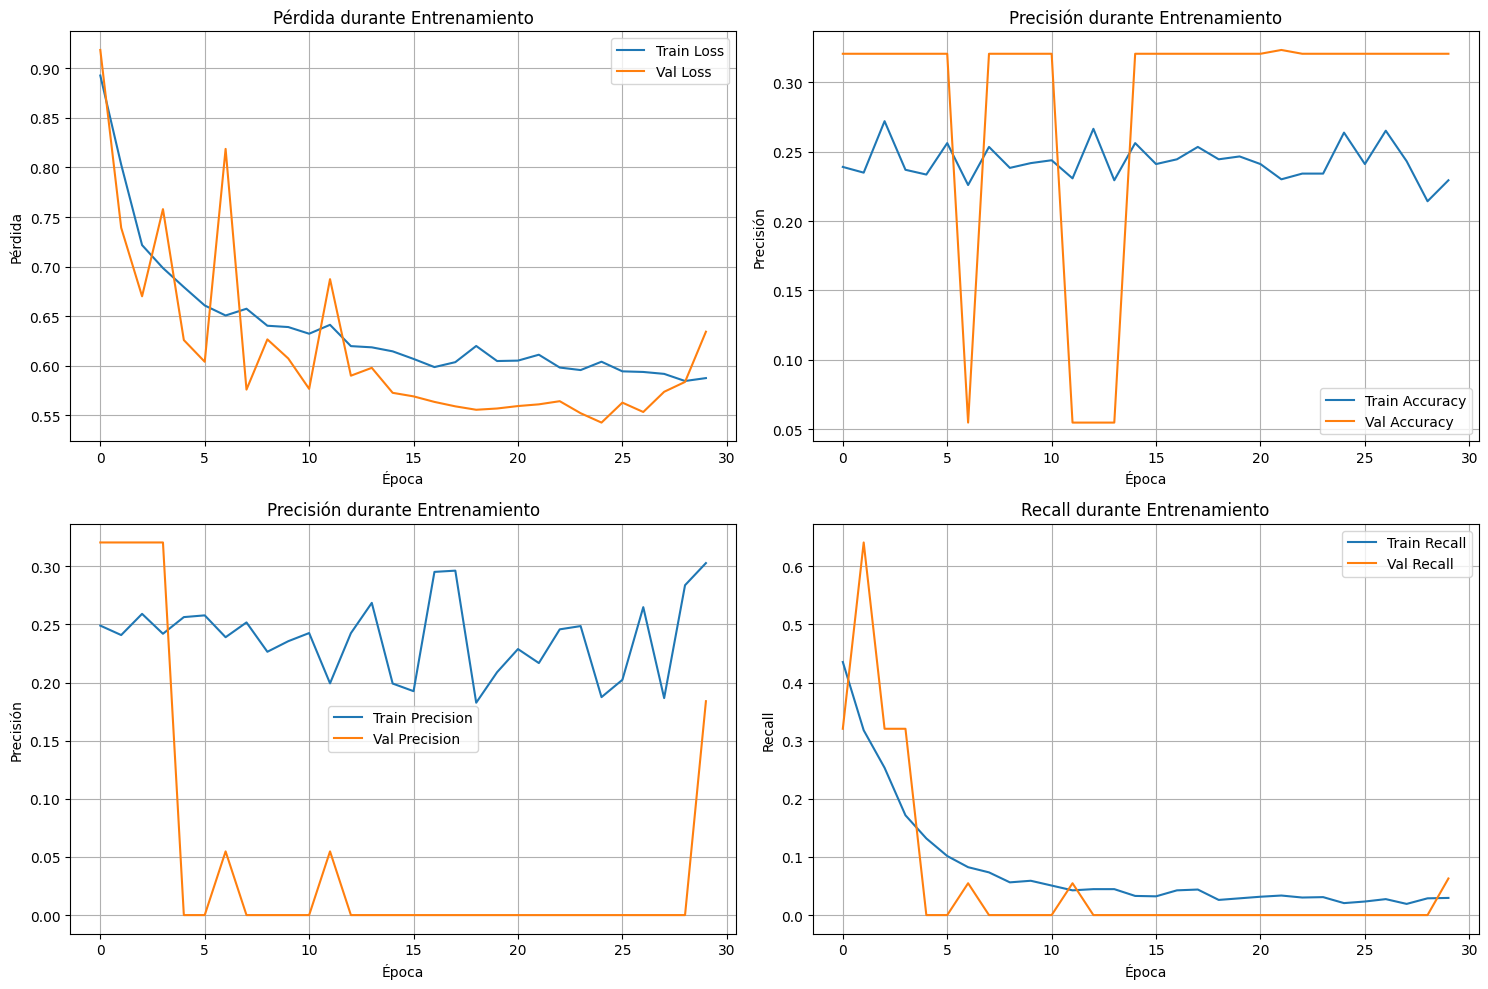

In [ ]:
#Genera gráficas del entrenamiento para análisis visual
def plot_training_history(history):
  fig, axes = plt.subplots(2, 2, figsize=(15, 10))

  # Pérdida
  axes[0, 0].plot(history.history['loss'], label='Train Loss')
  axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
  axes[0, 0].set_title('Pérdida durante Entrenamiento')
  axes[0, 0].set_xlabel('Época')
  axes[0, 0].set_ylabel('Pérdida')
  axes[0, 0].legend()
  axes[0, 0].grid(True)

  # Precisión
  axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy')
  axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy')
  axes[0, 1].set_title('Precisión durante Entrenamiento')
  axes[0, 1].set_xlabel('Época')
  axes[0, 1].set_ylabel('Precisión')
  axes[0, 1].legend()
  axes[0, 1].grid(True)

  # Precisión por clase
  if 'precision' in history.history:
    axes[1, 0].plot(history.history['precision'], label='Train Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
    axes[1, 0].set_title('Precisión durante Entrenamiento')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Precisión')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

  # Recall por clase
  if 'recall' in history.history:
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
    axes[1, 1].set_title('Recall durante Entrenamiento')
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

  plt.tight_layout()
  plt.show()

# Ejecutar
plot_training_history(history)

## ***Pruebas con Datos de Test***

In [ ]:
# Cargar y preprocesar datos de test
#Evalúa el modelo en el conjunto de test de Kaggle
def evaluate_on_test_set():
  # Cargar datos de test
  test_df = pd.read_csv("/content/plant_raw/test.csv")

  # Preprocesar imágenes de test (similar a train pero sin augmentation)
  test_images = []
  for img_id in test_df['image_id']:
    img_path = f"/content/plant_raw/images/{img_id}.jpg"
    img = preprocess_image(img_path)
    test_images.append(img)

  test_images = np.array(test_images)

  # Hacer predicciones
  predictions = cnn_model.predict(test_images)

  # Crear submission para Kaggle
  submission_df = test_df[['image_id']].copy()
  submission_df['healthy'] = predictions[:, 0]
  submission_df['multiple_diseases'] = predictions[:, 1]
  submission_df['rust'] = predictions[:, 2]
  submission_df['scab'] = predictions[:, 3]

  # Guardar submission
  submission_df.to_csv('/content/submission.csv', index=False)
  print("Submission file creado: /content/submission.csv")

  return predictions, submission_df

# Ejecutar evaluación en test
test_predictions, submission_df = evaluate_on_test_set()

57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step
Submission file creado: /content/submission.csv
